In [1]:
from __future__ import print_function, division
from io import open
import string
import re
import random

import os
import sys
import argparse
import time
import math

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F

from sklearn.metrics import roc_auc_score  
from sklearn.metrics import roc_curve 

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

try:
    import cPickle as pickle
except:
    import pickle

In [19]:
    
#import self-defined modules
# import model_LR 
# import Loaddata
# import TrainVT

import new.model as model
import new.Loaddata as Loaddata
import new.TrainVaTe as TVT

#import Loaddata function of some sort 

# check GPU availability
use_cuda = torch.cuda.is_available()
use_cuda

False

In [5]:
parser = argparse.ArgumentParser(description='30 Hospital Readmission Model with Pytorch')
# learning
parser.add_argument('-lr', type=float, default=0.001, help='initial learning rate [default: 0.001]')
#parser.add_argument('-epochs', type=int, default=256, help='number of epochs for train [default: 256]')
#parser.add_argument('-batch-size', type=int, default=64, help='batch size for training [default: 64]')
#parser.add_argument('-save-dir', type=str, default='snapshot', help='where to save the snapshot')
#parser.add_argument('-save-best', type=bool, default=True, help='whether to save when get best performance')
# data 
parser.add_argument('-seq_file', type = str, default = 'data/cerner/hospital_data/h143.visits' , help='the path to the Pickled file containing visit information of patients')
parser.add_argument('-label_file', type = str, default = 'data/cerner/hospital_data/h143.labels', help='the path to the Pickled file containing label information of patients')
parser.add_argument('-validation_ratio', type = float, default = 0.1, help='validation data size [default: 0.1]')
parser.add_argument('-test_ratio', type = float, default = 0.1, help='test data size [default: 0.2]')
# model
parser.add_argument('-which_model', type = str, default = 'LR', help='choose from {"LR", "CNN", "RNN"}')
parser.add_argument('-input_size', type = int, default =20000, help='input dimension')
#parser.add_argument('-dropout', type=float, default=0.5, help='the probability for dropout [default: 0.5]')
#parser.add_argument('-max-norm', type=float, default=3.0, help='l2 constraint of parameters [default: 3.0]')
#parser.add_argument('-embed-dim', type=int, default=128, help='number of embedding dimension [default: 128]')
#parser.add_argument('-kernel-num', type=int, default=100, help='number of each kind of kernel')
#parser.add_argument('-kernel-sizes', type=str, default='3,4,5', help='comma-separated kernel size to use for convolution')

# option
#parser.add_argument('-snapshot', type=str, default=None, help='filename of model snapshot [default: None]')
#parser.add_argument('-test', action='store_true', default=False, help='train or test')

_StoreAction(option_strings=['-input_size'], dest='input_size', nargs=None, const=None, default=20000, type=<class 'int'>, choices=None, help='input dimension', metavar=None)

In [6]:
# a block to simulate args reading from command line 
args = parser.parse_args(args=[])
args.seq_file = 'data/cerner/hospital_data/h143.visits'
args.label_file = 'data/cerner/hospital_data/h143.labels'
args.which_model = 'RNN'
args.input_size = 20000
args.lr = 0.001

In [20]:
# load and prepare data
set_x = pickle.load(open(args.seq_file, 'rb'), encoding='bytes')
set_y = pickle.load(open(args.label_file, 'rb'),encoding='bytes')

#preprocessing
# LR needs to have input format of list; list of list for NN models
if args.which_model == 'LR':
    model_x = []
    for patient in set_x:
        model_x.append([each for visit in patient for each in visit])  
else: 
    model_x = set_x     
    
merged_set= [(set_y[i],model_x[i]) for i in range(len(set_y))] 


print("\nLoading and preparing data...")    
train1, valid1, test1 = Loaddata.load_data(merged_set)
print("\nSample data after split:")  
print(train1[0])

print("model is", args.which_model)


Loading and preparing data...

Sample data after split:
(0, [[1667, 144, 62, 85], [1667, 144, 62, 85]])
model is RNN


In [23]:
# model loading part
if args.which_model == 'LR': 
    ehr_model = model_LR.EHR_LR(input_size = args.input_size, hidden_size = 16)
elif args.which_model == 'CNN':
    ehr_model = model_CNN.EHR_CNN(args) #MODIFY THE NAME WHEN FINALIZED
else: 
    ehr_model = model.EHR_RNN(args.input_size , embed_dim = 16, eb_mode = 'sum', dropout = 0, hidden_size = 128)
if use_cuda:
    ehr_model = ehr_model.cuda()


optimizer = optim.Adam(ehr_model.parameters(), lr=args.lr, weight_decay=0.001)

In [ ]:
# train, validation and  test 
train_loss= TVT.train(train1, model = ehr_model, optimizer = optimizer )
# print('\n training loss:')
# print(train_loss)

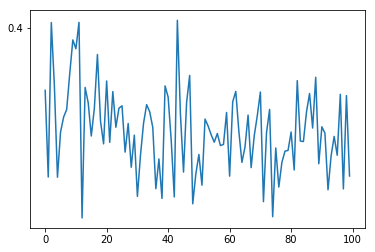

In [56]:
TVT.showPlot(train_loss)


 validation auc: 0.737349918337


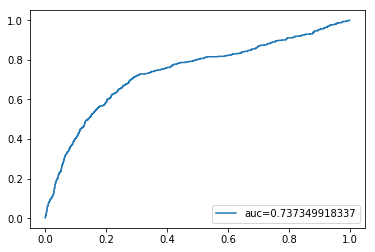


 test auc: 0.776729404105


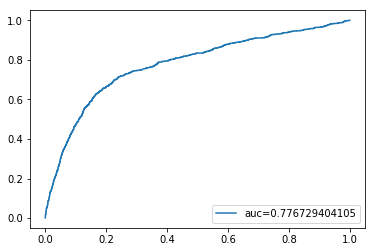

In [57]:
y_real, y_cal= TVT.evaluation(valid1, model = ehr_model)
auc = roc_auc_score(y_real, y_cal)
print("\n validation auc:", auc)
TVT.auc_plot(y_real, y_cal)

y_real, y_cal= TVT.evaluation(test1, model = ehr_model)
auc = roc_auc_score(y_real, y_cal)
print("\n test auc:", auc)
TVT.auc_plot(y_real, y_cal)